# TP53 Methods - Analyze Interesting Proteins

### From our previous tests, we have identified several proteins of interest to investigate more thoroughly
### We chose a few that stood out/were known to be related to the cell cycle: AURKA, BORA, XPO1, CDK1, TPX2, PLK1, CABLES1, XRN2

### Standard imports, including CPTAC package

In [2]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC.Endometrial as CPTAC

Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


### Set up initial dataframes and variables

In [4]:
gene='TP53'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()
transcriptomics = CPTAC.get_transcriptomics()

# A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.241del','p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]

# Get a list of patient identifiers for those who have mutations in the hotspot
hotspot_patients_both_keys = mutated_hotspot[['Clinical_Patient_Key', 'Patient_Id']]
hotspot_patients = hotspot_patients_both_keys['Clinical_Patient_Key']

## AURKA

### Proteomics analysis
### Note: AURKA not in phosphoproteomics data

All TP53 mutation and AURKA: 1.6061961577564404e-05
Hotspot TP53 mutation and AURKA: 2.218884225024604e-06
Non-hotspot TP53 mutation and AURKA: 0.023411607865453363


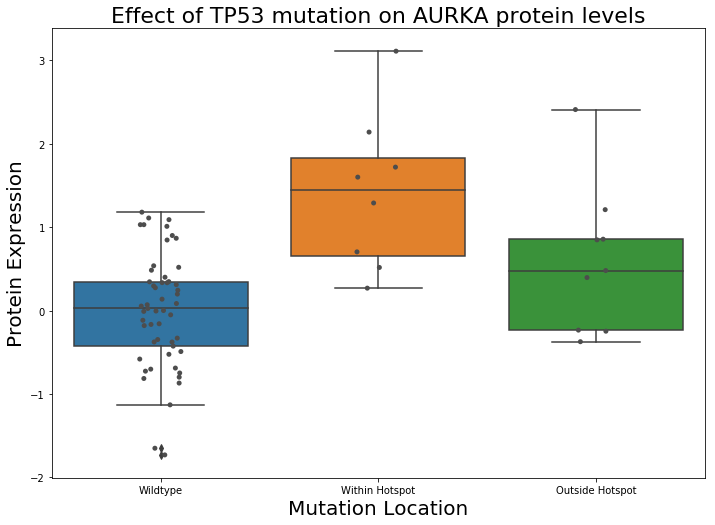

In [8]:
gene = 'TP53'
protein = 'AURKA'
#1.  merge the mutation status of P53 and the proteomics data of P53
p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
#2. now set up a new column for mutations that are within the hotspot
p53_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)

#3.  now make two new DFs, one for people with a hotspot mutation, one for all the wildtype cancer patients.
allmutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
mutatedhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Within Hotspot']
wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
nonhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Outside Hotspot']

ttestall = scipy.stats.ttest_ind(allmutated[protein], wt[protein])
ttesthtspt = scipy.stats.ttest_ind(mutatedhtspt[protein], wt[protein])
ttest_non_htspt = scipy.stats.ttest_ind(nonhtspt[protein], wt[protein])
print("All TP53 mutation and " + protein + ": " + str(ttestall[1]))
print("Hotspot TP53 mutation and " + protein + ": " + str(ttesthtspt[1]))
print("Non-hotspot TP53 mutation and " + protein + ": " + str(ttest_non_htspt[1]))
    
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " protein levels", fontsize='22')
plt.show()

## BORA

### Note: BORA not found in proteomics data

Site BORA-S212: 0.002679165254406512 (all mutations vs hotspot)
Not enough mutated values for site BORA-S327
Not enough mutated values for site BORA-S374
Not enough mutated values for site BORA-S400


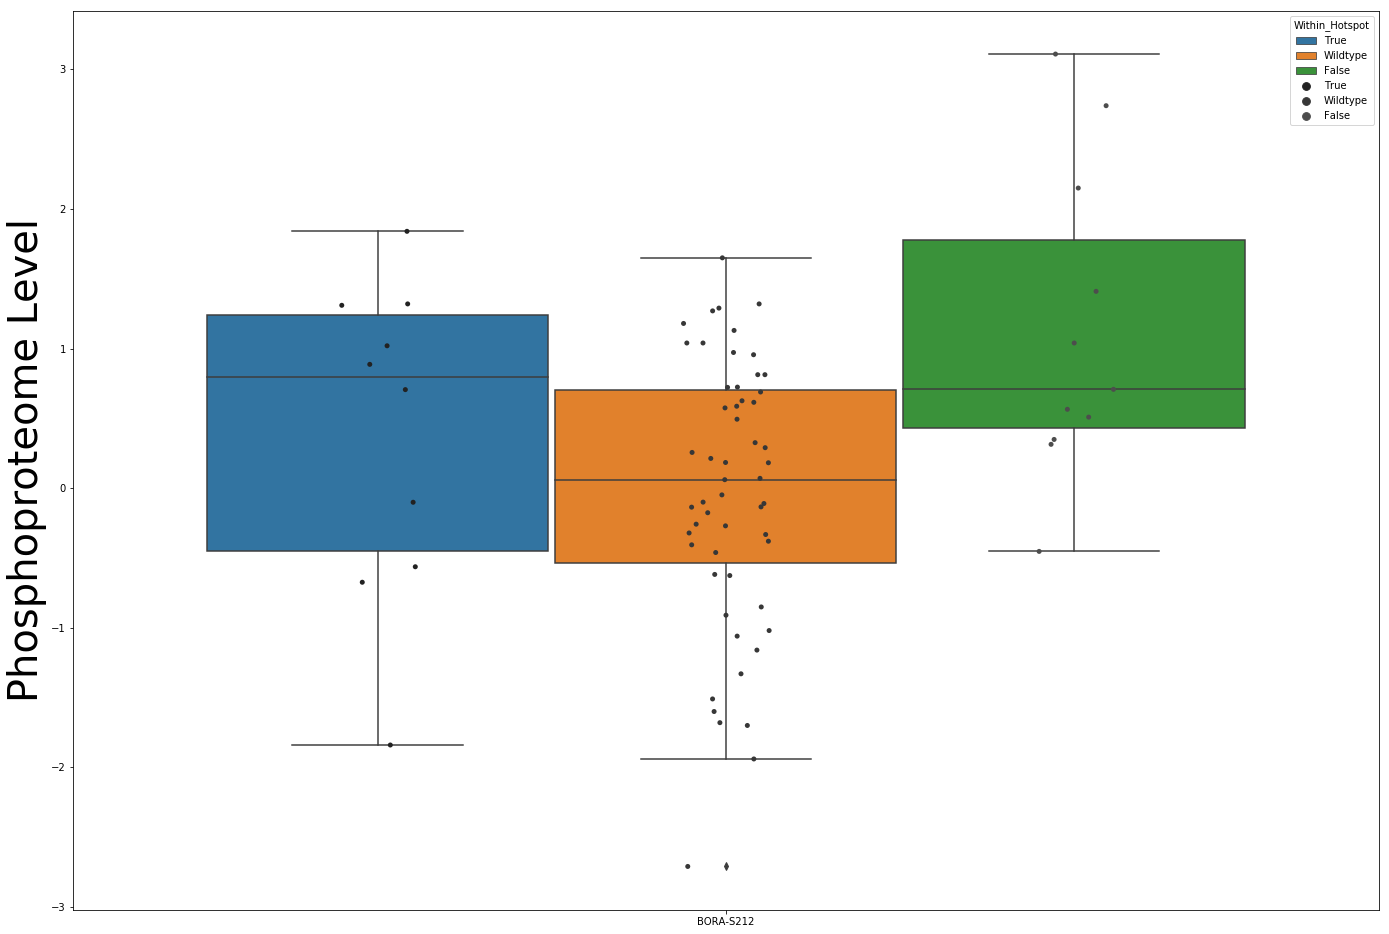

In [10]:
protein = 'BORA'
pattern = re.compile(protein)

# 1. Create a dataframe combining phosphosite data with TP53 mutation status; select for tumor samples
p53_mutations_protein = CPTAC.compare_mutations(phos, protein, gene)
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

# 2. Make a new column for mutation location relative to hotspot
p53_mutations_protein['Within_Hotspot'] = False
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein.drop('Mutation', axis=1)

# 3. Begin constructing a dataframe for plotting, starting only with the mutation location
plotdf = p53_mutations_protein[['Within_Hotspot']]

# 4. Set a cutoff for significance
pcutoff = 0.05/len(p53_mutations_protein.columns)

for site in p53_mutations_protein.columns:
    if (site != 'Within_Hotspot' and site != 'Mutation'):
        sitedf = p53_mutations_protein[[site, 'Within_Hotspot']].dropna(axis=0)
        mutated = sitedf.loc[sitedf['Within_Hotspot'] != 'Wildtype']
        wt = sitedf.loc[sitedf['Within_Hotspot'] == 'Wildtype']
        if mutated.empty:
            print("Not enough mutated values for site " + site)
            continue
        if wt.empty:
            print("Not enough wildtype values for site " + site)
            continue
        if len(mutated[site]) < 2:
            print("Not enough mutated values for site " + site)
            continue
        ttest = scipy.stats.ttest_ind(mutated[site], wt[site])
        if ttest[1] < pcutoff:
            print("Site " + site + ": " + str(ttest[1]) + " (all mutations vs hotspot)")
            plotdf = plotdf.join(p53_mutations_protein[site])
        else:
            continue
            print(site + " not significant")
            
plotdf = pd.melt(plotdf, id_vars = ['Within_Hotspot'], var_name = 'Site', value_name = 'Phos')
plotdf = plotdf.dropna(axis = 0)
            
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)

#Create the plot
boxplt = sns.boxplot(x='Site', y='Phos', hue='Within_Hotspot', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phos', hue='Within_Hotspot', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Phosphoproteome Level', fontsize='40')
boxplt.tick_params(labelsize='10')

## XPO1

All TP53 mutation and XPO1: 1.6459193780890785e-08
Hotspot TP53 mutation and XPO1: 1.876559260610166e-06
Non-hotspot TP53 mutation and XPO1: 5.556336118188905e-05


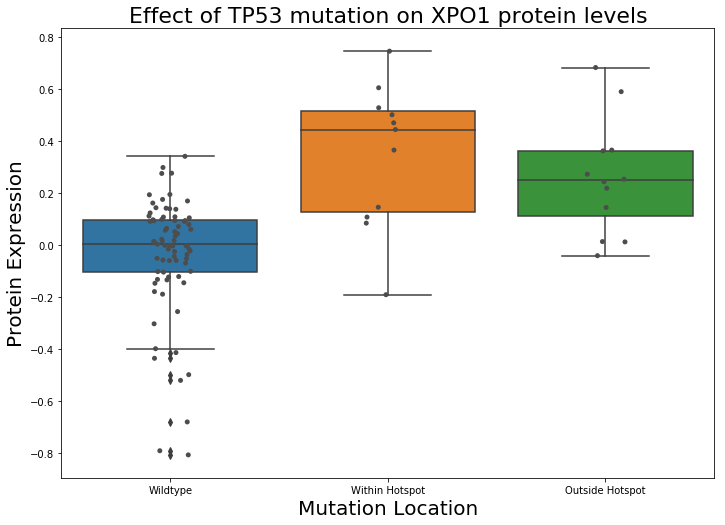

In [12]:
gene = 'TP53'
protein = 'XPO1'

#1.  merge the mutation status of P53 and the proteomics data of P53
p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
#2. now set up a new column for mutations that are within the hotspot
p53_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)

#3.  now make two new DFs, one for people with a hotspot mutation, one for all the wildtype cancer patients.
allmutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
mutatedhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Within Hotspot']
wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
nonhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Outside Hotspot']

ttestall = scipy.stats.ttest_ind(allmutated[protein], wt[protein])
ttesthtspt = scipy.stats.ttest_ind(mutatedhtspt[protein], wt[protein])
ttest_non_htspt = scipy.stats.ttest_ind(nonhtspt[protein], wt[protein])
print("All TP53 mutation and " + protein + ": " + str(ttestall[1]))
print("Hotspot TP53 mutation and " + protein + ": " + str(ttesthtspt[1]))
print("Non-hotspot TP53 mutation and " + protein + ": " + str(ttest_non_htspt[1]))
    
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " protein levels", fontsize='22')
plt.show()

## XRN2

All TP53 mutation and XRN2: 0.0027551813661251
Hotspot TP53 mutation and XRN2: 8.099557420058749e-07
Non-hotspot TP53 mutation and XRN2: 0.7941939049474052


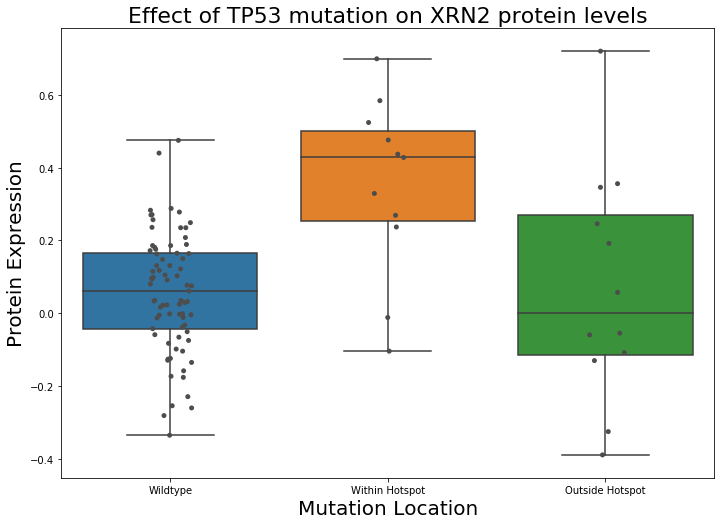

In [13]:
gene = 'TP53'
protein = 'XRN2'

#1.  merge the mutation status of P53 and the proteomics data of P53
p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
#2. now set up a new column for mutations that are within the hotspot
p53_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)

#3.  now make two new DFs, one for people with a hotspot mutation, one for all the wildtype cancer patients.
allmutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
mutatedhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Within Hotspot']
wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
nonhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Outside Hotspot']

ttestall = scipy.stats.ttest_ind(allmutated[protein], wt[protein])
ttesthtspt = scipy.stats.ttest_ind(mutatedhtspt[protein], wt[protein])
ttest_non_htspt = scipy.stats.ttest_ind(nonhtspt[protein], wt[protein])
print("All TP53 mutation and " + protein + ": " + str(ttestall[1]))
print("Hotspot TP53 mutation and " + protein + ": " + str(ttesthtspt[1]))
print("Non-hotspot TP53 mutation and " + protein + ": " + str(ttest_non_htspt[1]))
    
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " protein levels", fontsize='22')
plt.show()

## TPX2

### Proteomic analysis

All TP53 mutation and TPX2: 3.425330074424473e-09
Hotspot TP53 mutation and TPX2: 1.598760371601635e-07
Non-hotspot TP53 mutation and TPX2: 2.5030371169701337e-05


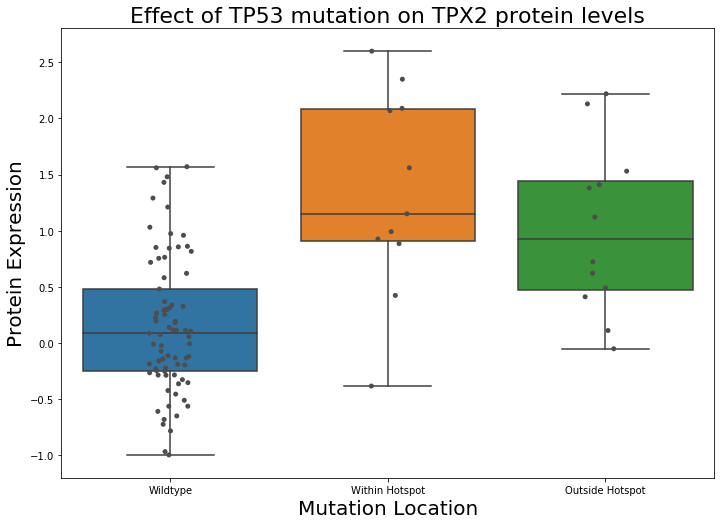

In [14]:
gene = 'TP53'
protein = 'TPX2'

#1.  merge the mutation status of P53 and the proteomics data of P53
p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
#2. now set up a new column for mutations that are within the hotspot
p53_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)

#3.  now make two new DFs, one for people with a hotspot mutation, one for all the wildtype cancer patients.
allmutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
mutatedhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Within Hotspot']
wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
nonhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Outside Hotspot']

ttestall = scipy.stats.ttest_ind(allmutated[protein], wt[protein])
ttesthtspt = scipy.stats.ttest_ind(mutatedhtspt[protein], wt[protein])
ttest_non_htspt = scipy.stats.ttest_ind(nonhtspt[protein], wt[protein])
print("All TP53 mutation and " + protein + ": " + str(ttestall[1]))
print("Hotspot TP53 mutation and " + protein + ": " + str(ttesthtspt[1]))
print("Non-hotspot TP53 mutation and " + protein + ": " + str(ttest_non_htspt[1]))
    
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " protein levels", fontsize='22')
plt.show()

### Phosphoproteomic analysis

Site TPX2-S121: 1.7423650715376062e-05 (all mutations vs hotspot)
Site TPX2-S125: 1.7423650715376062e-05 (all mutations vs hotspot)
Site TPX2-S486: 1.720312510779992e-05 (all mutations vs hotspot)
Site TPX2-S738: 0.0001351933552728578 (all mutations vs hotspot)
Site TPX2-T147: 0.001248473432764909 (all mutations vs hotspot)
Site TPX2-T369: 3.584870082506112e-05 (all mutations vs hotspot)


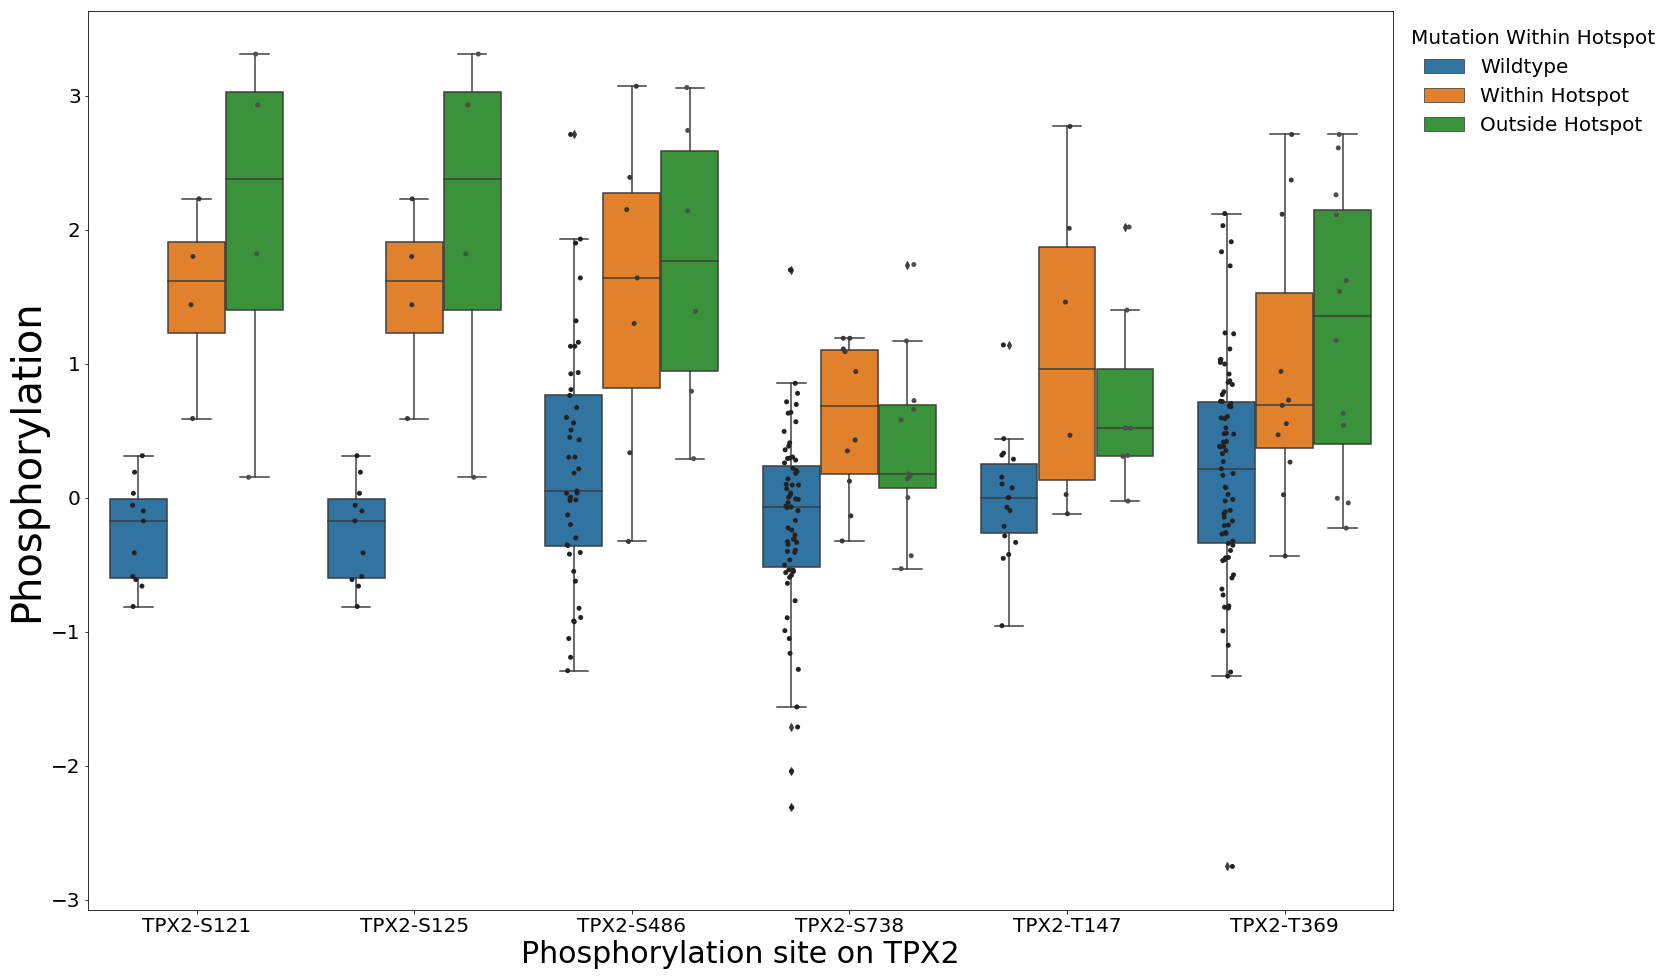

In [30]:
protein = 'TPX2'
pattern = re.compile(protein)

# 1. Create a dataframe combining phosphosite data with TP53 mutation status; select for tumor samples
p53_mutations_protein = CPTAC.compare_mutations(phos, protein, gene)
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

# 2. Make a new column for mutation location relative to hotspot
p53_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'

# 3. Begin constructing a dataframe for plotting, starting only with the mutation location
plotdf = p53_mutations_protein[['Within_Hotspot']]

# 4. Set a cutoff for significance
pcutoff = 0.05/len(p53_mutations_protein.columns)

# 5. Go through each site on the protein and check for significance with TP53 mutation
for site in p53_mutations_protein.columns:
    if (site != 'Within_Hotspot' and site != 'Mutation'):
        sitedf = p53_mutations_protein[[site, 'Within_Hotspot']].dropna(axis=0)
        mutated = sitedf.loc[sitedf['Within_Hotspot'] != 'Wildtype']
        wt = sitedf.loc[sitedf['Within_Hotspot'] == 'Wildtype']
        if mutated.empty:
            print("Not enough mutated values for site " + site)
            continue
        if wt.empty:
            print("Not enough wildtype values for site " + site)
            continue
        if len(mutated[site]) < 2:
            print("Not enough mutated values for site " + site)
            continue
        ttest = scipy.stats.ttest_ind(mutated[site], wt[site])
        if ttest[1] < pcutoff:
            print("Site " + site + ": " + str(ttest[1]) + " (all mutations vs hotspot)")
            plotdf = plotdf.join(p53_mutations_protein[site])
        else:
            continue
            print(site + " not significant")
            
plotdf = pd.melt(plotdf, id_vars = ['Within_Hotspot'], var_name = 'Site', value_name = 'Phos')
plotdf = plotdf.dropna(axis = 0)
            
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)

#Create the plot
boxplt = sns.boxplot(x='Site', y='Phos', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phos', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('Phosphorylation site on ' + protein, fontsize = '30')
boxplt.set_ylabel('Phosphorylation', fontsize='40')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], title='Mutation Within Hotspot', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))

## PLK1

All TP53 mutation and PLK1: 7.295527266933368e-06
Hotspot TP53 mutation and PLK1: 0.000496998797197547
Non-hotspot TP53 mutation and PLK1: 0.0004663020299181568


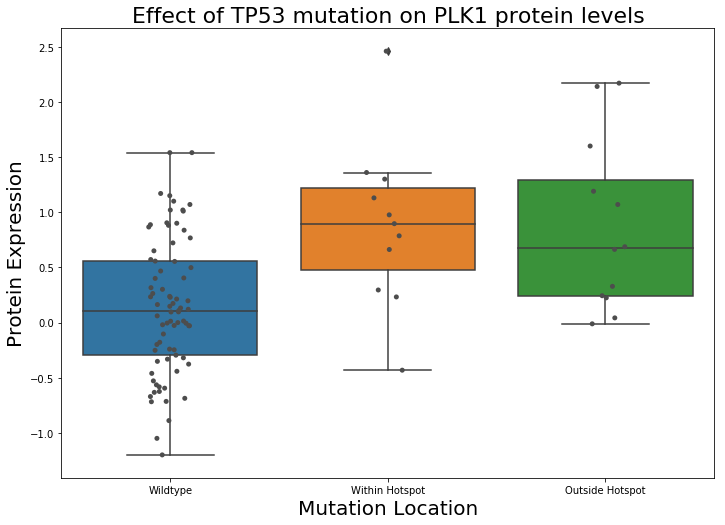

In [17]:
gene = 'TP53'
protein = 'PLK1'

#1.  merge the mutation status of P53 and the proteomics data of P53
p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
#2. now set up a new column for mutations that are within the hotspot
p53_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)

#3.  now make two new DFs, one for people with a hotspot mutation, one for all the wildtype cancer patients.
allmutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
mutatedhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Within Hotspot']
wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
nonhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Outside Hotspot']

ttestall = scipy.stats.ttest_ind(allmutated[protein], wt[protein])
ttesthtspt = scipy.stats.ttest_ind(mutatedhtspt[protein], wt[protein])
ttest_non_htspt = scipy.stats.ttest_ind(nonhtspt[protein], wt[protein])
print("All TP53 mutation and " + protein + ": " + str(ttestall[1]))
print("Hotspot TP53 mutation and " + protein + ": " + str(ttesthtspt[1]))
print("Non-hotspot TP53 mutation and " + protein + ": " + str(ttest_non_htspt[1]))
    
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " protein levels", fontsize='22')
plt.show()

## CABLES1

All TP53 mutation and CABLES1: 1.1764566319746612e-05
Hotspot TP53 mutation and CABLES1: 0.002448641920096314
Non-hotspot TP53 mutation and CABLES1: 7.106237044120236e-05


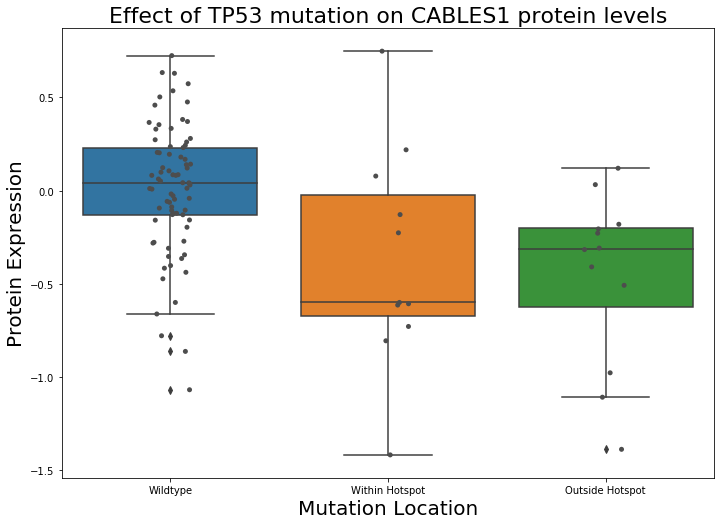

In [16]:
gene = 'TP53'
protein = 'CABLES1'

#1.  merge the mutation status of P53 and the proteomics data of P53
p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
#2. now set up a new column for mutations that are within the hotspot
p53_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)

#3.  now make two new DFs, one for people with a hotspot mutation, one for all the wildtype cancer patients.
allmutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
mutatedhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Within Hotspot']
wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
nonhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Outside Hotspot']

ttestall = scipy.stats.ttest_ind(allmutated[protein], wt[protein])
ttesthtspt = scipy.stats.ttest_ind(mutatedhtspt[protein], wt[protein])
ttest_non_htspt = scipy.stats.ttest_ind(nonhtspt[protein], wt[protein])
print("All TP53 mutation and " + protein + ": " + str(ttestall[1]))
print("Hotspot TP53 mutation and " + protein + ": " + str(ttesthtspt[1]))
print("Non-hotspot TP53 mutation and " + protein + ": " + str(ttest_non_htspt[1]))
    
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " protein levels", fontsize='22')
plt.show()

## CDK1

All TP53 mutation and CDK1: 8.797191558024237e-05
Hotspot TP53 mutation and CDK1: 0.0009486058850723273
Non-hotspot TP53 mutation and CDK1: 0.0082082398365111


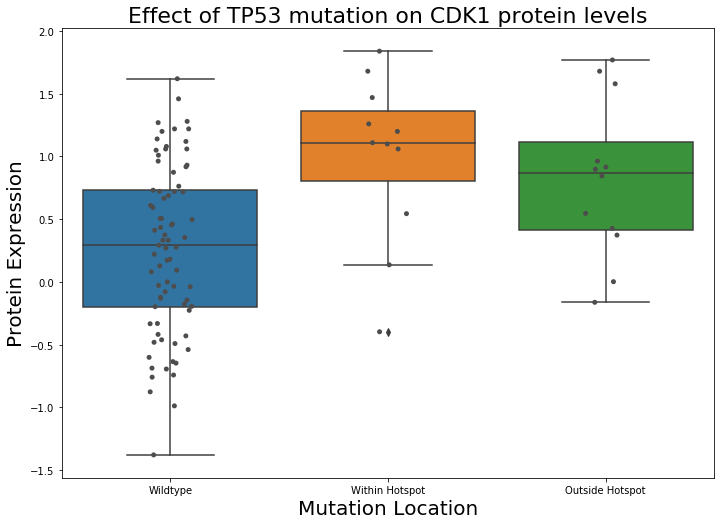

In [15]:
gene = 'TP53'
protein = 'CDK1'

#1.  merge the mutation status of P53 and the proteomics data of P53
p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
#2. now set up a new column for mutations that are within the hotspot
p53_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)

#3.  now make two new DFs, one for people with a hotspot mutation, one for all the wildtype cancer patients.
allmutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
mutatedhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Within Hotspot']
wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
nonhtspt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Outside Hotspot']

ttestall = scipy.stats.ttest_ind(allmutated[protein], wt[protein])
ttesthtspt = scipy.stats.ttest_ind(mutatedhtspt[protein], wt[protein])
ttest_non_htspt = scipy.stats.ttest_ind(nonhtspt[protein], wt[protein])
print("All TP53 mutation and " + protein + ": " + str(ttestall[1]))
print("Hotspot TP53 mutation and " + protein + ": " + str(ttesthtspt[1]))
print("Non-hotspot TP53 mutation and " + protein + ": " + str(ttest_non_htspt[1]))
    
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " protein levels", fontsize='22')
plt.show()